In [1]:
import networkx as nx 
import matplotlib.pyplot as plt 
import numpy as np 
from scipy.stats import poisson
import math
from collections import defaultdict
plt.rcParams['figure.dpi'] = 100

## Defining the Parameters

In [2]:
N = 200 # number of nodes 200
Q = 4 # number of groups
q = 50 # group size 50
mu = 0.025 # outside connections (Mxing parameter)
beta = 0.4 # infection rate
r = 1 # recovery rate
k_avg = 3 # average degree 


### Assigning Communities

In [3]:
commu_names = [ _ for _ in range(1,(Q+1))] # name of the communities
G = nx.Graph()
for i in range(N): # assigning the communities as attributes to the graph
    G.add_node(i, community =  math.floor(i/q) + 1)


## Community Structure

### Stochastic-Block Model (SBM)

In [4]:
def create_SBM(G, Q, q, mu, k_avg):

    p_in = k_avg*(1-mu)/(q-1) # probability of interactions within a group
    p_out = k_avg*mu/(N-q) # probability of interactions with nodes outside of its own group

    for i in G:
        groupmates = [node for node, attrs in G.nodes(data=True) if attrs.get('community') == math.floor(i/q)+1 and node != i]
        outsiders = [node for node, attrs in G.nodes(data=True) if attrs.get('community') != math.floor(i/q)+1 ]
        for neighbor in groupmates: 
            if np.random.rand() < p_in:
                G.add_edge(i, neighbor)
        for outsider in outsiders:
            if np.random.rand() < p_out:
                G.add_edge(i, outsider)
    return G




## Measuring Correlation Among the Community Structures of the Layers

##### Maximally Correlated Communities

In [5]:
# Normalized Mutual Information (NMI) = 1
G1 = create_SBM(G, Q, q, mu, k_avg)
G2 = create_SBM(G, Q, q, mu, k_avg)

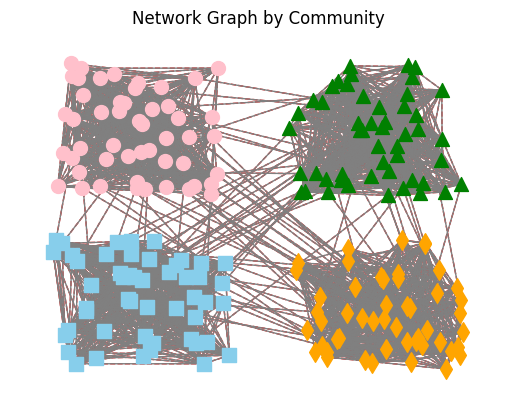

<Figure size 600x600 with 0 Axes>

In [112]:
def custom_layout_by_community_attribute(G, frame_size=(1, 1), padding=0.1, inner_padding=0.05):
    positions = {}
    width, height = frame_size
    communities = set(nx.get_node_attributes(G, 'community').values())  # Extract unique community IDs
    num_communities = len(communities)
    sqrt_num = int(np.ceil(np.sqrt(num_communities)))  # Arrange in a square layout
    community_size = (width - 2 * padding) / sqrt_num
    
    for community_id in communities:
        i = list(communities).index(community_id)  # Convert to list to get index
        center_x = padding + (i % sqrt_num) * community_size + community_size / 2
        center_y = height - (padding + (i // sqrt_num) * community_size + community_size / 2)
        
        nodes_in_community = [node for node, data in G.nodes(data=True) if data.get('community') == community_id]
        for node in nodes_in_community:
            x = center_x + np.random.uniform(-community_size / 2 + inner_padding, community_size / 2 - inner_padding)
            y = center_y + np.random.uniform(-community_size / 2 + inner_padding, community_size / 2 - inner_padding)
            positions[node] = (x, y)
    
    return positions

# Create a custom layout based on community
pos = custom_layout_by_community_attribute(G1)

color_mapping = {1: 'pink', 2: 'green', 3: 'skyblue', 4: 'orange'}
shape_mapping = {1: 'o', 2: '^', 3: 's', 4: 'd'}  # Circle, Triangle, Square, diamond

# adding the attributes of the second layer to G1 for plotting. 
communities_layer2 = list(nx.get_node_attributes(G2, 'community').values())  # Extract unique community IDs
for i in range(N):
    G1.nodes[i]['community_layer2'] = communities_layer2[i]


for node, data in G1.nodes(data=True):
    nx.draw_networkx_nodes(G1, pos, nodelist=[node], 
                           node_color=color_mapping[data['community']],
                           node_shape=shape_mapping[data['community_layer2']], 
                           node_size=100)

# Plot edges for G1
nx.draw_networkx_edges(G1, pos, edge_color='red', style='dashed')

# # Optionally, plot edges for G2 if needed
nx.draw_networkx_edges(G2, pos, edge_color='gray', style='solid')
plt.title("Network Graph by Community")
plt.axis('off')  # Turn off the axis

# Plotting
plt.figure(figsize=(6, 6))
# Draw nodes with colors based on their community


plt.show()


In [6]:
G2.edges()

EdgeView([(0, 46), (0, 47), (0, 17), (0, 2), (0, 48), (0, 6), (0, 12), (1, 24), (1, 12), (1, 49), (1, 25), (1, 29), (1, 5), (1, 19), (1, 42), (1, 48), (1, 121), (2, 3), (2, 25), (2, 26), (2, 30), (2, 9), (2, 37), (2, 14), (2, 27), (2, 7), (2, 15), (2, 29), (2, 31), (3, 7), (3, 9), (3, 14), (3, 27), (3, 30), (3, 47), (3, 8), (3, 24), (3, 20), (3, 22), (3, 45), (4, 26), (4, 38), (4, 39), (4, 6), (4, 29), (4, 40), (4, 48), (4, 5), (4, 42), (5, 16), (5, 23), (5, 39), (5, 48), (5, 133), (5, 17), (5, 28), (5, 29), (5, 45), (5, 46), (5, 9), (5, 26), (6, 25), (6, 28), (6, 30), (6, 32), (6, 35), (6, 40), (6, 27), (7, 12), (7, 20), (7, 10), (7, 21), (7, 33), (7, 23), (7, 49), (7, 31), (8, 9), (8, 18), (8, 21), (8, 27), (8, 36), (8, 38), (8, 43), (8, 44), (8, 191), (8, 19), (8, 24), (8, 13), (8, 39), (9, 48), (9, 41), (9, 14), (9, 24), (9, 34), (9, 35), (10, 19), (10, 31), (10, 13), (10, 22), (10, 16), (10, 27), (10, 34), (11, 15), (11, 22), (11, 27), (11, 12), (11, 36), (11, 38), (11, 26), (11, 

In [7]:
G1.edges()

EdgeView([(0, 46), (0, 47), (0, 17), (0, 2), (0, 48), (0, 6), (0, 12), (1, 24), (1, 12), (1, 49), (1, 25), (1, 29), (1, 5), (1, 19), (1, 42), (1, 48), (1, 121), (2, 3), (2, 25), (2, 26), (2, 30), (2, 9), (2, 37), (2, 14), (2, 27), (2, 7), (2, 15), (2, 29), (2, 31), (3, 7), (3, 9), (3, 14), (3, 27), (3, 30), (3, 47), (3, 8), (3, 24), (3, 20), (3, 22), (3, 45), (4, 26), (4, 38), (4, 39), (4, 6), (4, 29), (4, 40), (4, 48), (4, 5), (4, 42), (5, 16), (5, 23), (5, 39), (5, 48), (5, 133), (5, 17), (5, 28), (5, 29), (5, 45), (5, 46), (5, 9), (5, 26), (6, 25), (6, 28), (6, 30), (6, 32), (6, 35), (6, 40), (6, 27), (7, 12), (7, 20), (7, 10), (7, 21), (7, 33), (7, 23), (7, 49), (7, 31), (8, 9), (8, 18), (8, 21), (8, 27), (8, 36), (8, 38), (8, 43), (8, 44), (8, 191), (8, 19), (8, 24), (8, 13), (8, 39), (9, 48), (9, 41), (9, 14), (9, 24), (9, 34), (9, 35), (10, 19), (10, 31), (10, 13), (10, 22), (10, 16), (10, 27), (10, 34), (11, 15), (11, 22), (11, 27), (11, 12), (11, 36), (11, 38), (11, 26), (11, 

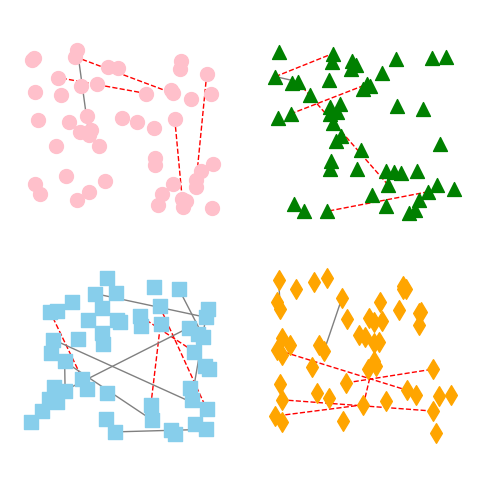

In [6]:

# Assuming G1 and G2 are your graph layers
# Assuming community_membership_layer1 defines the communities for both layers

colors = ['pink', 'green', 'skyblue', 'orange']
shapes = ['o', '^', 's', 'd']  # Circle, Triangle, Square, diamond

# Create a custom layout for your graph
def custom_layout(communities, frame_size=(1, 1), padding=0.1, inner_padding=0.05):
    """
    communities: List of lists, where each sublist is a list of nodes in a community.
    frame_size: Tuple (width, height) of the plot area.
    padding: Outer padding for the plot.
    inner_padding: Padding between communities.
    Returns a dictionary of positions keyed by node.
    """
    positions = {}
    width, height = frame_size
    num_communities = len(communities)
    sqrt_num = int(np.ceil(np.sqrt(num_communities)))  # Arrange in a square layout
    community_size = (width - 2*padding) / sqrt_num
    
    for i, community in enumerate(communities):
        # Determine the center of the community region
        center_x = padding + (i % sqrt_num) * community_size + community_size / 2
        center_y = height - (padding + (i // sqrt_num) * community_size + community_size / 2)
        
        # Generate random positions within the community region
        for node in community:
            x = center_x + np.random.uniform(-community_size/2 + inner_padding, community_size/2 - inner_padding)
            y = center_y + np.random.uniform(-community_size/2 + inner_padding, community_size/2 - inner_padding)
            positions[node] = (x, y)
    
    return positions

# Assuming you have a list of community memberships for layer 1
# community_membership_layer1 = [[0, 1, 2, ..., 49], [50, 51, ..., 99], [100, 101,..., 149], [150, ..., 199]]
pos = custom_layout(community_membership_layer1)

# Now you can plot your graph using the positions from the custom layout
plt.figure(figsize=(6, 6))

# Plot nodes with community color and shape
for community_id, community_nodes in enumerate(community_membership_layer1):
    nx.draw_networkx_nodes(G1, pos,
                           nodelist=community_nodes,
                           node_color=colors[community_id],
                           node_shape=shapes[community_id],
                           node_size=100,
                           label=f"Community {community_id+1}")

# Plot edges for G1
nx.draw_networkx_edges(G1, pos, edge_color='red', style='dashed')

# Optionally, plot edges for G2 if needed
nx.draw_networkx_edges(G2, pos, edge_color='gray', style='solid')

# Show the legend
# plt.legend(scatterpoints=1)

# Display the graph
plt.axis('off')
plt.show()


##### Un-Correlated Communities

In [38]:
# NMI = 0

def swapping_communities(N, r, Q, q, community_membership):
    new_community_membership = [[] for _ in range(Q)]
    list_of_nodes = list(range(N))
    count=0
    for i in list(list_of_nodes):
        if np.random.rand() < r:
            count += 1
            # print(i)
            # outsiders = [node for node in list(range(N)) if node not in community_membership[math.floor(i/q)]]
            outsiders = [node for node in list(list_of_nodes) if node not in community_membership[math.floor(i/q)]]
            random_outsider_node = np.random.choice(outsiders)
            print(i, ", ", random_outsider_node)
            print("outs. =",outsiders)
            # print(random_outsider_node)
            print("insi. = " , community_membership[math.floor(i/q)])
            
            index = next((i for i, inner_list in enumerate(community_membership) if random_outsider_node in inner_list), None)

            
            new_community_membership[index].append(i)
            new_community_membership[math.floor(i/q)].append(random_outsider_node)
            
            community_membership[math.floor(i/q)].remove(i)
            community_membership[index].remove(random_outsider_node)
            
            list_of_nodes.remove(random_outsider_node) # not to consider the nodes that have already switched communities
            list_of_nodes.remove(i) # not to consider the nodes that have already switched communities

            # print(count)
            # print(list_of_nodes)
    return new_community_membership

In [39]:
r = 1 # the probablity of swapping edges 
# community_membership_layer2 = community_membership_layer1
G1 = create_SBM(N, Q, q, mu, k_avg, community_membership_layer1)
community_membership_layer2 = swapping_communities(N, r, Q, q, community_membership_layer1)
G2 = create_SBM(N, Q, q, mu, k_avg, community_membership_layer2)

0 ,  196
outs. = [50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199]
insi. =  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
1 ,  72
outs. = [50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 6

ValueError: list.remove(x): x not in list

## Disease Dynamics

In [ ]:

def SIR_dynamics(G, beta, r):
    # initial conditions:
    I = {np.random.choice(G.nodes())} # starting with one random infected individual
    S = set(G.nodes()) - I # all the remaining individuals are the susceptibles
    R = set()

    S_records, I_records, R_records = [], [], [] # keeping records of how the networks evolves

    # max_t = 1000 

    while len(I) != 0: 
        I_temp, R_temp = set(), set() # defining these temporary sets to avoid infinite loops
        for i in I: # at each time step every infected, infects its neighbors with probability (at rate) beta
            for neighbor in G.neighbors(i):
                if neighbor in S: 
                    if np.random.rand() < beta:
                        I_temp.add(neighbor)
            if np.random.rand() < r:
                R_temp.add(i)
        
        S -= I_temp
        I = (I - R_temp) | I_temp
        R |= R_temp 

        S_records.append(S)
        I_records.append(I)
        R_records.append(R)
        
        # if len(I) == 0:
        #     break

    return S_records,I_records, R_records
